<a href="https://colab.research.google.com/github/JelenaKitanovic/qa_system_covid/blob/main/IR_JelenaKitanovic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistem za pretrazivanje informacija o bolesti COVID-19 implementiran koriscenjem Haystack framework-a

Cilj ovog projekta je bio da izgradi sistem za odgovore na pitanja (tzv. QA system) koji bi na postavljeno pitanje pronasao odgovore medju dostupnim dokumentima. Za realizaciju ovog projekta, koriscen je [Haystack framework](https://haystack.deepset.ai/overview/intro) koji omogucava BLABLA.

U ovom projektu koriscen je podskup skupa podataka 
[COVID-19 Open Research Dataset Challenge (CORD-19)](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Originalni skup se sastoji od preko 500,000 strucnih radova, od kojih je preko 200,000 o COVID-19, SARS-CoV-2, i slicnim virusima. 

Napomena: Radi lakseg treniranja i reprodukcije programa, prilkom izrade ovog projekta koriscen je podskup od oko 10,000 radova. Folder sa tim radovima mozete pronaci na ovoj adresi: ///Moj drive

## Ucitavanje skupa podataka

Kako su podaci u navedenom direktorijumu u json formatu, potrebno je da iz njih izvucemo potrebne informacije i prilagodimo format onome koji nama odgovara. 

Za dalju analizu bice nam dovoljan naziv rada (title), sazetak (abstract), sam tekst rada (full_text) i imena autora (authors).

In [ ]:
import numpy as np
import pandas as pd
import os
import json
import re
from tqdm import tqdm

directory_path = "/content/drive/MyDrive/COVID"
docs=[]
counts=0

for file in tqdm(os.listdir(directory_path)):#What is an f string?
  file_path = directory_path + f"/{file}"
  j = json.load(open(file_path, "rb"))
        #Taking last 7 characters. it removes the 'PMC' appended to the beginning
        #also paperid in pdf_json are guids and hard to plot in the graphs hence the substring
  paper_id = j['paper_id']
  paper_id = paper_id[-7:]
  title = j['metadata']['title']
      
  authors = ''
  for author in j['metadata']['authors']:
    authors = authors + author['first'] + ' ' + author['last'] + ', '
  authors = authors[:-2]
  try:
    abstract = j['abstract'][0]['text']
  except:
    abstract = ''
            
  full_text = ''
  for text in j['body_text']:
    full_text += text['text']       
  
docs.append([paper_id, title, abstract, full_text, authors])  
df = pd.DataFrame(docs,columns=['paper_id','title','abstract','full_text', 'authors'])

print(df.shape)
df.head()

 90%|████████▉ | 5026/5586 [02:08<03:54,  2.39it/s]

In [ ]:
df.describe()

,paper_id,title,abstract,full_text
count,2593,2593,2593,2593
unique,2593,2308,1832,2592
top,0c1830f,,,Healthcare workers (HCWs) are presumed to be at high risk for coronavirus di...
freq,1,270,751,2


# Word cloud

There are 496245 words in the combination of all review.


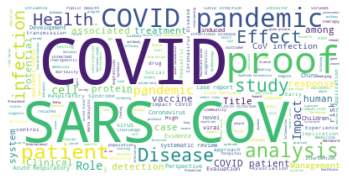

In [ ]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline 

text = " ".join(title for title in df.title)
print ("There are {} words in the combination of all review.".format(len(text)))
# There are 31661073 words in the combination of all review.
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["et al", "one", "use", "group", "two", "may", "using", "used", "new", "time", "data", "based", "method", "result", "model", 'journal', 'Pre'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
!pip install grpcio-tools==1.34.1
!pip install git+https://github.com/deepset-ai/haystack.git

     |████████████████████████████████| 2.5 MB 7.5 MB/s 
  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-req-build-0v2ifadi
  Running command git clone -q https://github.com/deepset-ai/haystack.git /tmp/pip-req-build-0v2ifadi
     |████████████████████████████████| 204 kB 7.6 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 79 kB 9.8 MB/s 
     |████████████████████████████████| 321 kB 62.1 MB/s 
     |████████████████████████████████| 332 kB 59.4 MB/s 
     |████████████████████████████████| 85 kB 5.0 MB/s 
     |████████████████████████████████| 981 kB 55.3 MB/s 
     |████████████████████████████████| 3.0 MB 47.7 MB/s 
     |████████████████████████████████| 85 kB 5.3 MB/s 
     |████████████████████████████████| 5.6 MB 66.0 MB/s 
     |████████████████████████████████| 100 kB 11.4 MB/s 
     |████████████████████████████████| 8.4 MB 12.5 MB/s 
     |████████

## Instalacija najnovije verzije Haystack-a

## Ucitavanje potrebnih funkcija i biblioteka

In [ ]:
# from haystack import Finder
from haystack.preprocessor.cleaning import clean_wiki_text
from haystack.preprocessor.utils import convert_files_to_dicts, fetch_archive_from_http
from haystack.reader.farm import FARMReader
from haystack.reader.transformers import TransformersReader
from haystack.utils import print_answers

ModuleNotFoundError: ignored

## Ucitavanje dokumenata u DocumentStore

Haystack trazi odgovore na pitanja u dokumentima koji se nalaze u [DocumentStore](https://haystack.deepset.ai/usage/document-store)-u. Postoji vise implementacija DocumentStore-a (ElasticsearchDocumentStore, SQLDocumentStore, MilvusDocumentStore, InMemoryDocumentStore, etc.)

U ovom projektu je koriscen ElasticsearchDocumentStore zato sto dolazi sa implementiranim algoritmima kao sto su BM25 i full-text queries.

In [ ]:
# In Colab / No Docker environments: Start Elasticsearch from source
! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
! chown -R daemon:daemon elasticsearch-7.9.2

import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.9.2/bin/elasticsearch'],
                   stdout=PIPE, stderr=STDOUT,
                   preexec_fn=lambda: os.setuid(1)  # as daemon
                  )
# wait until ES has started
! sleep 30

In [ ]:
# initiating ElasticSearch
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore
document_store = ElasticsearchDocumentStore(host="localhost", username="", password="", index="document")

09/07/2021 09:39:24 - INFO - elasticsearch -   HEAD http://localhost:9200/ [status:200 request:0.013s]
09/07/2021 09:39:24 - INFO - elasticsearch -   HEAD http://localhost:9200/document [status:200 request:0.005s]
09/07/2021 09:39:24 - INFO - elasticsearch -   GET http://localhost:9200/document [status:200 request:0.006s]
09/07/2021 09:39:24 - INFO - elasticsearch -   PUT http://localhost:9200/document/_mapping [status:200 request:0.019s]
09/07/2021 09:39:24 - INFO - elasticsearch -   HEAD http://localhost:9200/label [status:200 request:0.003s]


Da bismo ucitali dokumente u ElasticsearchDocumentStore potrebno je da oni budu u sledecem formatu:
<br>
[
*    {"name": "some-document-name, "text": "abcd"}
*    {"name": "<some-document-name>, "text": "<the-actual-text>"}
*    {"name": "<some-document-name>, "text": "<the-actual-text>"}
<br>
]

(Optionally: you can also add more key-value-pairs here, that will be indexed as fields in Elasticsearch and can be accessed later for filtering or shown in the responses of the Finder)

We will use title column to pass as name and full_text column to pass as the text
# Now, let's write the dicts containing documents to our DB.


In [ ]:
# Now, let's write the dicts containing documents to our DB.
dictionary = df[['title', 'full_text']].rename(columns={'title':'name','full_text':'text'}).to_dict(orient='records')
dictionary[:3]


[{'name': 'PfSWIB, a potential chromatin regulator for var gene regulation and parasite development in Plasmodium falciparum',
  'text': 'Plasmodium falciparum, which causes malignant malaria such as cerebral malaria (CM) or pregnancy-associated malaria (PAM) [1, 2] , is the cause of death to 435,000 individuals annually [3] . Plasmodium falciparum erythrocyte membrane protein 1 (PfEMP1), which is encoded by the var gene family comprising approximately 60 members, is the major virulence factor involved in the antigenic variation and clinical pathogenicity of falciparum malaria [4, 5] . It is remarkable that the expression of var family members is mutually exclusive. For each parasite at a time, only one or a few var genes are expressed, while the remaining members are silenced [6, 7] . In each generation, P. falciparum is able to express different var genes, and the switches in var gene expression lead to antigenic variation of PfEMP1, which results in immune evasion and chronic infect

In [ ]:
document_store.write_documents(dictionary)

09/07/2021 09:39:36 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.800s]
09/07/2021 09:39:38 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.242s]
09/07/2021 09:39:41 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.320s]
09/07/2021 09:39:43 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:2.223s]


In [ ]:
from haystack.retriever.sparse import ElasticsearchRetriever
retriever = ElasticsearchRetriever(document_store=document_store)

In [ ]:
# Load a  local model or any of the QA models on
# Hugging Face's model hub (https://huggingface.co/models)

reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True, context_window_size=1000)
# TransformersReader

09/07/2021 09:41:14 - INFO - farm.utils -   Using device: CUDA 
09/07/2021 09:41:14 - INFO - farm.utils -   Number of GPUs: 1
09/07/2021 09:41:14 - INFO - farm.utils -   Distributed Training: False
09/07/2021 09:41:14 - INFO - farm.utils -   Automatic Mixed Precision: None
Some weights of the model checkpoint at deepset/roberta-base-squad2 were not used when initializing RobertaModel: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at deepset/roberta-base-squad2 and a

Stavaljamo Reader i Retreiver u Pipeline.

In [ ]:
from haystack.pipeline import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader, retriever)

In [ ]:
prediction = pipe.run(query="COVID death rates Europe", top_k_retriever=10, top_k_reader=5)
# What is the impact of coronavirus on babies

09/07/2021 09:41:26 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.026s]
Inferencing Samples: 100%|██████████| 2/2 [00:02<00:00,  1.07s/ Batches]


In [ ]:
# print_answers(prediction, details="minimal")

print(f"Question: {prediction['query']}")
print("\n")
for i in range(3):
    print(f"#{i+1}")
    print(f"Answer: {prediction['answers'][i]['answer']}")
    print(f"Research Paper: {prediction['answers'][i]['meta']['name']}")
    print(f"Context: {prediction['answers'][i]['context']}")
    print('\n\n')

Question: COVID death rates Europe


#1
Answer: 50 percent
Research Paper: Will Covid-19 put the public back in public transport? A UK perspective
Context: ly decreased by between 80% and 95% in the earlier stages of lockdowns, although there is evidence that ridership is creeping up again as restrictions are eased, but typically only to about half of pre-pandemic levels. Evidence gathered by the Transport Strategy Centre at Imperial College, London (TSC, 2020) after the first wave of the pandemic in July 2020 shows that Asian metros, which fell by less, had returned to about 70 percent of normal levels by July, whilst those in Europe were at 50 percent and in the Americas at between 20 and 30 per cent. It is clear that the fall in traffic has created financial problems for operators from lost revenue. Regardless of whether these operators are fully in the public sector, or franchised operators or fully private they have needed financial support to maintain at least a basic level of se

In [ ]:
#@title Unesite pitanje ili skup reci za koji zelite da se izvrsi pretraga:

query = 'Is covid deadly for babies?' #@param {type:"string"}


import ipywidgets as widgets
from IPython.display import display
button = widgets.Button(description="Search")
output = widgets.Output()

def on_button_clicked(b):
  # Display the message within the output widget.
  prediction = pipe.run(query=query, top_k_retriever=10, top_k_reader=5)
  print(f"Question: {prediction['query']}")
  print("\n")
  for i in range(3):
      print(f"#{i+1}")
      print(f"Answer: {prediction['answers'][i]['answer']}")
      print(f"Research Paper: {prediction['answers'][i]['meta']['name']}")
      print(f"Context: {prediction['answers'][i]['context']}")
      print('\n\n')


button.on_click(on_button_clicked)
display(button, output)


Button(description='Search', style=ButtonStyle())

Output()

09/07/2021 10:07:03 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.020s]
Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  4.43 Batches/s]

Question: Is covid deadly for babies?


#1
Answer: rare
Research Paper: Value Frameworks for Vaccines: Which Dimensions Are Most Relevant?
Context: he disease (against which VACCINEX protects) is more common in disadvantaged groups.The disease (against which VACCINEX protects) is rare in disadvantaged groups.Target group: affects migrantsThe disease (against which VACCINEX protects) is more common in migrants.The disease (against which VACCINEX protects) is rare in migrants.Target group: affects babiesThe disease (against which VACCINEX protects) is more common in babies and young children.The disease (against which VACCINEX protects) is rare in babies and young children.Target group: affects elderlyThe disease (against which VACCINEX protects) is more common in elderly people.The disease (against which VACCINEX protects) is rare in elderly people.Target group: affects LGBTThe disease (against which VACCINEX protects) is more common in people from the LGBT (lesbian-gay-bisexual-transge